# Home Credit risk assessment

## Topic

Home Credit, a service dedicated to providing lines of credit to the unbanked population, is sharing its previous loan reports to be used in a machine learning project. The aim of the project is to be able to predict whether a client will pay up their
loan or not. The dataset consists of several datasources:

- application_train/application_test: the main training and testing data with information about each loan application at Home Credit. Every loan has its own row and is identified by the feature SK_ID_CURR. The training application data comes with the TARGET indicating 0: the loan was repaid or 1: the loan was not repaid.
- bureau: data concerning client's previous credits from other financial institutions. Each previous credit has its own row in bureau, but one loan in the application data can have multiple previous credits.
- bureau_balance: monthly data about the previous credits in bureau. Each row is one month of a previous credit, and a single previous credit can have multiple rows, one for each month of the credit length.
- previous_application: previous applications for loans at Home Credit of clients who have loans in the application data. Each current loan in the application data can have multiple previous loans. Each previous application has one row and is identified by the feature SK_ID_PREV.
- POS_CASH_BALANCE: monthly data about previous point of sale or cash loans clients have had with Home Credit. Each row is one month of a previous point of sale or cash loan, and a single previous loan can have many rows.
- credit_card_balance: monthly data about previous credit cards clients have had with Home Credit. Each row is one month of a credit card balance, and a single credit card can have many rows.
- installments_payment: payment history for previous loans at Home Credit. There is one row for every made payment and one row for every missed payment.
- HomeCredit_columns_description.csv, an example of the expected submission file. In this first notebook, we will only be working with the main train and test data sets. The others will be used in future notebooks to further improve the model.

## Objective
Build and train at least 4 classification models that can tell with high accuracy whether or not the client pays off their loan.

## Summary

- Importing libraries and loading datasets
- Exploratory data analysis / Dataviz
- Feature engineering
- Logistic Regression
- Random Forest Classifier
- XGBoost
- SVM
- Test data predictions
- Conclusion 

### Importing necessary libraries and loading data sets

In [50]:
# Library to handle dataframes
import pandas as pd
import numpy as np

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns


# Undersample data 
from imblearn.under_sampling import RandomUnderSampler

# Preprocess data
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer

# Find relevant features
from boruta import BorutaPy

# Split data and perform gridsearch 
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV

# Classification algorithms
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.svm import SVC

# Evaluate performances
from sklearn import metrics
from sklearn.metrics import  confusion_matrix, classification_report, accuracy_score, precision_score
from pprint import pprint
from collections import Counter


In [51]:
# Load the datasets
train_df = pd.read_csv(r'C:\Users\imane\OneDrive\Desktop\Risk_Assessment\application_train.csv', sep =",")
test_df = pd.read_csv(r'C:\Users\imane\OneDrive\Desktop\Risk_Assessment\application_test.csv', sep =",")

### Exploratory Data Analysis / Dataviz

In [52]:
# Quick look at the train set 
train_df.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [53]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(41), object(16)
memory usage: 286.2+ MB


In [54]:
test_df.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
4,100038,Cash loans,M,Y,N,1,180000.0,625500.0,32067.0,625500.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


In [55]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48744 entries, 0 to 48743
Columns: 121 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(40), object(16)
memory usage: 45.0+ MB


Data frames are pretty big and contain lots of columns. The train set contains the target columns while the test set doesn't.
In the target column we can see two classes, either 0 or 1. 0 means that the client has repaid their loan and 1 means the opposite. 

In [56]:
# Check the missing values and their percentages
# Create a function that returns a dataframe containing columns names and the percentage of missing values in it 
# Keep only those who have missing values of above 60%
def table (df):
    missing = df.isnull().sum()
    missing_perc = df.isnull().sum() * 100/ len(df)
    missing_df = pd.concat([missing,missing_perc], axis = 1)
    missing_df = missing_df.rename(columns={0:"n missing",1:"n percentage"})
    return missing_df

In [57]:
# Apply the function on the train set
missing_train = table(train_df)
missing_train.drop(missing_train.index[(missing_train["n percentage"] < 60)],axis = 0 , inplace = True)
missing_train = missing_train.round(1)
missing_train = missing_train.sort_values(by = ["n percentage"],ascending = False)
missing_train = missing_train.reset_index()
missing_train

,index,n missing,n percentage
0,COMMONAREA_MEDI,214865,69.9
1,COMMONAREA_AVG,214865,69.9
2,COMMONAREA_MODE,214865,69.9
3,NONLIVINGAPARTMENTS_MEDI,213514,69.4
4,NONLIVINGAPARTMENTS_AVG,213514,69.4
5,NONLIVINGAPARTMENTS_MODE,213514,69.4
6,FONDKAPREMONT_MODE,210295,68.4
7,LIVINGAPARTMENTS_AVG,210199,68.4
8,LIVINGAPARTMENTS_MEDI,210199,68.4
9,LIVINGAPARTMENTS_MODE,210199,68.4


In [58]:
# Apply the function on the test set 
missing_test = table(test_df)
missing_test.drop(missing_test.index[(missing_test["n percentage"] < 60)],axis = 0 , inplace = True)
missing_test = missing_test.round(1)
missing_test = missing_test.sort_values(by = ["n percentage"],ascending = False)
missing_test = missing_test.reset_index()
missing_test

,index,n missing,n percentage
0,COMMONAREA_MEDI,33495,68.7
1,COMMONAREA_AVG,33495,68.7
2,COMMONAREA_MODE,33495,68.7
3,NONLIVINGAPARTMENTS_MEDI,33347,68.4
4,NONLIVINGAPARTMENTS_AVG,33347,68.4
5,NONLIVINGAPARTMENTS_MODE,33347,68.4
6,FONDKAPREMONT_MODE,32797,67.3
7,LIVINGAPARTMENTS_AVG,32780,67.2
8,LIVINGAPARTMENTS_MEDI,32780,67.2
9,LIVINGAPARTMENTS_MODE,32780,67.2


We see that the same columns from the data and test sets contain more than 60% empty values. These columns will be dropped later during feature selection

<AxesSubplot:title={'center':'Distribution of classes'}, ylabel='Frequency'>

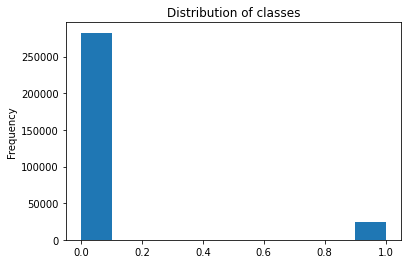

In [59]:
# Let's take a look at the distribution of the target classes
train_df["TARGET"].astype(int).plot.hist(title = "Distribution of classes")

There is a huge difference between the instances of 0 and 1. It'll be fixed by using undersampling later on (oversampling can also be used, but undersampling is the simplest choice in this case).

In [60]:
# A look at the datatypes we have in the set 
train_df.dtypes.value_counts()

float64    65
int64      41
object     16
dtype: int64

In [61]:
test_df.dtypes.value_counts()

float64    65
int64      40
object     16
dtype: int64

In [62]:
# Look at the number of entries of each unique categorical value per column
train_df.select_dtypes("object").apply(pd.Series.nunique, axis = 0)

NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64

In [63]:
test_df.select_dtypes("object").apply(pd.Series.nunique, axis = 0)

NAME_CONTRACT_TYPE             2
CODE_GENDER                    2
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               7
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             5
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64

By looking at the data types, we see that we have integers, floats and objects which are basically categorical. Then, we saw how many unique categories are there in each categorical features. So, for features with two a maximum of categories we'll use label encoding, and for those with more than 2 categories we'll use one hot encoding. But before that, we'll delete the two columns with the most categorical features (occupation type and organization type) because it is very costly for the computer to transform those when using ine-hot encoding from one side, and because they don't represent strong indicators as to whether the client would pay.

<AxesSubplot:title={'center':'Days of employment'}, ylabel='Frequency'>

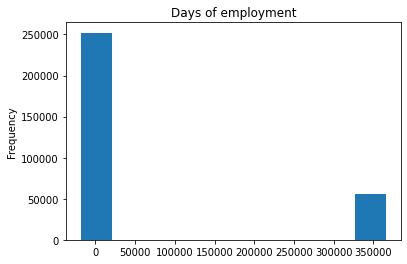

In [64]:
# Let's check the employment days column (this column is recorded in negative digits and in days)
train_df["DAYS_EMPLOYED"].plot.hist(title = "Days of employment")

<AxesSubplot:title={'center':'Days of employment'}, ylabel='Frequency'>

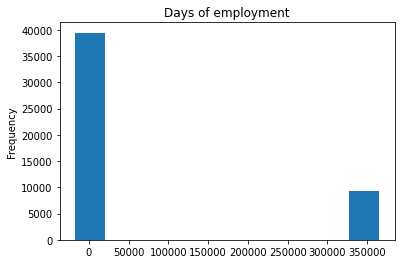

In [65]:
test_df["DAYS_EMPLOYED"].plot.hist(title = "Days of employment")

We notice the huge difference between the classes of employment days. Here the second class represents many instances where the number of days employed is above 350 000 (exactly 365 243) which is about 1000 years. Clearly these are anomalous values and they will be adjusted later on. 

In [66]:
train_df['DAYS_BIRTH'] = abs(train_df['DAYS_BIRTH'])
test_df['DAYS_BIRTH'] = abs(test_df['DAYS_BIRTH'])

Text(0, 0.5, 'Number of clients')

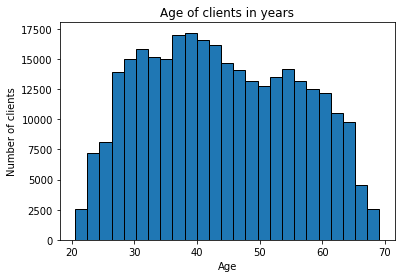

In [67]:
# A quick look at the age column 
plt.hist(train_df['DAYS_BIRTH'] / 365, edgecolor = 'k', bins = 25)
plt.title("Age of clients in years")
plt.xlabel("Age")
plt.ylabel("Number of clients")

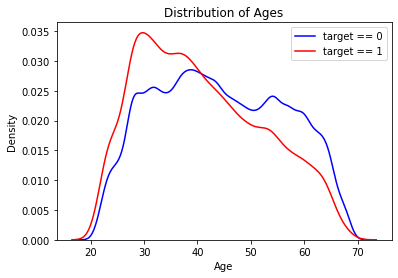

In [68]:
# Use KDE (Kernel Density Estimate) to see the probability density of each categorie in Target
# Target of 0 will show its curve in blue, target of 1 will show in red
sns.kdeplot(train_df.loc[train_df['TARGET'] == 0, 'DAYS_BIRTH'] / 365, label = 'target == 0', color = "blue")
sns.kdeplot(train_df.loc[train_df['TARGET'] == 1, 'DAYS_BIRTH'] / 365, label = 'target == 1', color = "red")
plt.xlabel('Age')
plt.ylabel('Density')
plt.title('Distribution of Ages')
plt.legend()

The age feature was also recorded in negatives and in days. We turned it into positive values in both the train and test set. That we took a look at the distribution of ages which looked pretty normal(between 20 and 70 years old).
The Kernel Density estimate though shows us that this feature is important because it clearly distinguishes between the payers and the non payers. Plus it shows us that younger people tend to default on their loan more often that older ones.

### Feature engineering 

##### Deleting columns with more than 60% empty values

In [69]:
m_col = list(missing_train["index"])
for col in m_col:
    if col in train_df.columns:
        train_df = train_df.drop([col], axis = 1)
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 105 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(49), int64(41), object(15)
memory usage: 246.3+ MB


In [70]:
m_col = list(missing_test["index"])
for col in m_col:
    if col in test_df.columns:
        test_df = test_df.drop([col], axis = 1)
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48744 entries, 0 to 48743
Columns: 104 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(49), int64(40), object(15)
memory usage: 38.7+ MB


We've deleted columns with more than 60% empty values and now have 105 columns remaining in the train set

##### Deleting columns with several categorical features

In [71]:
train_df = train_df.drop(["ORGANIZATION_TYPE"], axis = 1)
test_df = test_df.drop(["ORGANIZATION_TYPE"], axis = 1)

In [72]:
train_df = train_df.drop(["OCCUPATION_TYPE"], axis = 1)
test_df = test_df.drop(["OCCUPATION_TYPE"], axis = 1)


Now there are only 103 columns left in the train set 

##### Dealing with anomalous values in the days employed column

<AxesSubplot:title={'center':'Days of employment train set'}, ylabel='Frequency'>

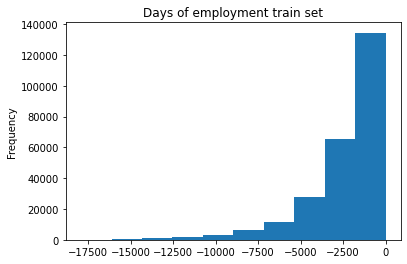

In [73]:
anomalies = train_df[train_df["DAYS_EMPLOYED"] >= 350000 ]
non_an = train_df[train_df["DAYS_EMPLOYED"] < 350000]
train_df["DAYS_EMPLOYED_ANO"] = train_df["DAYS_EMPLOYED"] >= 350000
train_df["DAYS_EMPLOYED"].replace({365243 : np.nan}, inplace = True)
train_df["DAYS_EMPLOYED"].plot.hist(title = "Days of employment train set")

<AxesSubplot:title={'center':'Days of employment test set'}, ylabel='Frequency'>

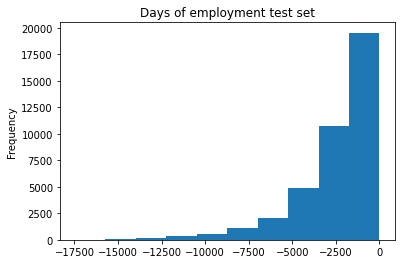

In [74]:
test_df["DAYS_EMPLOYED_ANO"] = test_df["DAYS_EMPLOYED"] >= 350000
test_df["DAYS_EMPLOYED"].replace({365243 : np.nan}, inplace = True)
test_df["DAYS_EMPLOYED"].plot.hist(title = "Days of employment test set")

Instead of replacing the anomalous values with the median or mean, we've replaced them with numpy not a number and added another column that tells us whether the number was replaced or not, in order to not unbalance any potential influence those particular values might have on the target

##### Balancing the data using undersampling

In [75]:
target = train_df["TARGET"].copy()
train_df.drop(["TARGET"], axis = 1)
under_sampler = RandomUnderSampler(random_state=0)
train_df, t_resampled = under_sampler.fit_resample(train_df,target)
train_df["TARGET"] = t_resampled
print(sorted(Counter(t_resampled).items()), t_resampled.shape)

[(0, 24825), (1, 24825)] (49650,)


<AxesSubplot:title={'center':'Distribution of classes'}, ylabel='Frequency'>

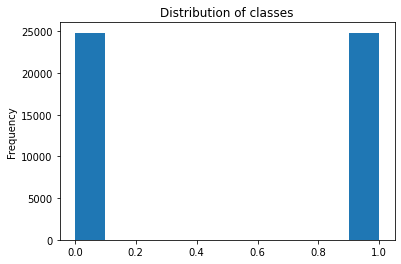

In [76]:
train_df["TARGET"].astype(int).plot.hist(title = "Distribution of classes")

After applying undersapling, we have now the same amount of instances 1 and 0. 

##### Categorical feautures encoding

###### Label encoding 

In [77]:
train = train_df.copy()
test = test_df.copy()
LE = LabelEncoder()
count = 0
for col in train.columns: 
    if train[col].dtype == "object":
        if len(list(train[col].unique())) <= 2:
            LE.fit(train[col])
            train[col] = LE.transform(train[col])
            test[col] = LE.transform(test[col])
            count += 1

##### One hot encoding

In [78]:
train = pd.get_dummies(train)
test = pd.get_dummies(test)
train.dtypes.value_counts()

float64    50
uint8      50
int64      40
int32       4
bool        1
dtype: int64

In [79]:
target = train["TARGET"].copy()
train = train.drop(["TARGET"], axis = 1)
train, test = train.align(test, join = "inner", axis = 1)
features = list(train.columns)
train["TARGET"] = target
print("Shape of the train dateframe", train.shape)

Shape of the train dateframe (49650, 143)


In [80]:
print("Shape of the test dataframe", test.shape)

Shape of the test dataframe (48744, 142)


We performed label encoding on columns with two categories and one hot encoding on columns with more than two classes. After that, we aligned the train and test sets to contain the same columns (except for target) 

#### Imputing empty values with the median

In [81]:
train = train.drop(["TARGET"], axis = 1)
imputer = SimpleImputer(strategy = 'median')
imputer.fit(train)
train = imputer.transform(train)
test = imputer.transform(test)

#### Scaling numerical values using normalization

In [82]:
scaler = MinMaxScaler(feature_range = (0, 1))
scaler.fit(train)
train = scaler.transform(train)
test = scaler.transform(test)

#### Features importances

In [83]:
# Get feature importances into a dataset
random_forest = RandomForestClassifier(n_estimators = 100, random_state = 50, verbose = 1, n_jobs = -1)
random_forest.fit(train,target)
ft_imp = random_forest.feature_importances_
imp_df = pd.DataFrame({"feature": features,"importance": ft_imp})
imp_df = imp_df.sort_values(by = ["importance"], ascending = False).reset_index()
imp_df.head(15)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    6.5s finished


,index,feature,importance
0,33,EXT_SOURCE_3,0.071455
1,32,EXT_SOURCE_2,0.068275
2,11,DAYS_BIRTH,0.037687
3,12,DAYS_EMPLOYED,0.036689
4,14,DAYS_ID_PUBLISH,0.033864
5,13,DAYS_REGISTRATION,0.032948
6,66,DAYS_LAST_PHONE_CHANGE,0.032679
7,8,AMT_ANNUITY,0.032219
8,0,SK_ID_CURR,0.031618
9,31,EXT_SOURCE_1,0.031157


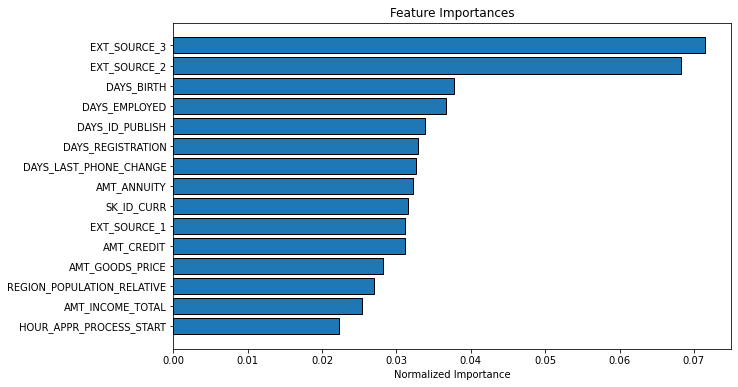

In [84]:
# Plot the 15 most important features
def plot_ft_imp(df):
    df['importance_normalized'] = df['importance'] / df['importance'].sum()
    plt.figure(figsize = (10, 6))
    ax = plt.subplot()
    ax.barh(list(reversed(list(df.index[:15]))), 
            df['importance_normalized'].head(15), 
            align = 'center', edgecolor = 'k')
    ax.set_yticks(list(reversed(list(df.index[:15]))))
    ax.set_yticklabels(df['feature'].head(15))
    plt.xlabel('Normalized Importance'); plt.title('Feature Importances')
    plt.show()
    
    return df
# Apply it to our case
bar_plot = plot_ft_imp(imp_df)

According to random forest's feature importances, the external source 3 and 2 are the two most important ones. We'll try Boruta's algorithm too and see if the results match 

#### Boruta's all relevant features algorithm

In [85]:
from boruta import BorutaPy
ft_selector = BorutaPy(random_forest, n_estimators='auto', verbose=2, random_state=1)
X = train.copy()
y = target.copy()
ft_selector.fit(X,y)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done 168 out of 168 | elapsed:   17.6s finished


Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	142
Rejected: 	0


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done 168 out of 168 | elapsed:   18.1s finished


Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	142
Rejected: 	0


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done 168 out of 168 | elapsed:   17.9s finished


Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	142
Rejected: 	0


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done 168 out of 168 | elapsed:   17.2s finished


Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	142
Rejected: 	0


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done 168 out of 168 | elapsed:   17.6s finished


Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	142
Rejected: 	0


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done 168 out of 168 | elapsed:   17.0s finished


Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	142
Rejected: 	0


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done 168 out of 168 | elapsed:   16.8s finished


Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	142
Rejected: 	0


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done 168 out of 168 | elapsed:   17.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


Iteration: 	8 / 100
Confirmed: 	0
Tentative: 	12
Rejected: 	130


[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed:    3.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


Iteration: 	9 / 100
Confirmed: 	8
Tentative: 	4
Rejected: 	130


[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed:    3.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


Iteration: 	10 / 100
Confirmed: 	8
Tentative: 	4
Rejected: 	130


[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed:    2.9s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


Iteration: 	11 / 100
Confirmed: 	8
Tentative: 	4
Rejected: 	130


[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed:    3.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


Iteration: 	12 / 100
Confirmed: 	8
Tentative: 	4
Rejected: 	130


[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed:    3.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


Iteration: 	13 / 100
Confirmed: 	8
Tentative: 	4
Rejected: 	130


[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed:    3.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


Iteration: 	14 / 100
Confirmed: 	8
Tentative: 	4
Rejected: 	130


[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed:    3.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


Iteration: 	15 / 100
Confirmed: 	8
Tentative: 	4
Rejected: 	130


[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed:    3.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


Iteration: 	16 / 100
Confirmed: 	8
Tentative: 	4
Rejected: 	130


[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed:    3.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


Iteration: 	17 / 100
Confirmed: 	8
Tentative: 	4
Rejected: 	130


[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed:    3.0s finished


Iteration: 	18 / 100
Confirmed: 	8
Tentative: 	4
Rejected: 	130


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed:    3.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


Iteration: 	19 / 100
Confirmed: 	8
Tentative: 	3
Rejected: 	131


[Parallel(n_jobs=-1)]: Done  46 out of  46 | elapsed:    2.8s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


Iteration: 	20 / 100
Confirmed: 	8
Tentative: 	3
Rejected: 	131


[Parallel(n_jobs=-1)]: Done  46 out of  46 | elapsed:    2.7s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


Iteration: 	21 / 100
Confirmed: 	8
Tentative: 	3
Rejected: 	131


[Parallel(n_jobs=-1)]: Done  46 out of  46 | elapsed:    2.7s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


Iteration: 	22 / 100
Confirmed: 	8
Tentative: 	3
Rejected: 	131


[Parallel(n_jobs=-1)]: Done  46 out of  46 | elapsed:    2.7s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


Iteration: 	23 / 100
Confirmed: 	8
Tentative: 	3
Rejected: 	131


[Parallel(n_jobs=-1)]: Done  46 out of  46 | elapsed:    3.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


Iteration: 	24 / 100
Confirmed: 	8
Tentative: 	3
Rejected: 	131


[Parallel(n_jobs=-1)]: Done  46 out of  46 | elapsed:    3.3s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


Iteration: 	25 / 100
Confirmed: 	8
Tentative: 	3
Rejected: 	131


[Parallel(n_jobs=-1)]: Done  46 out of  46 | elapsed:    3.4s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


Iteration: 	26 / 100
Confirmed: 	8
Tentative: 	3
Rejected: 	131


[Parallel(n_jobs=-1)]: Done  46 out of  46 | elapsed:    3.4s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


Iteration: 	27 / 100
Confirmed: 	8
Tentative: 	3
Rejected: 	131


[Parallel(n_jobs=-1)]: Done  46 out of  46 | elapsed:    3.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


Iteration: 	28 / 100
Confirmed: 	8
Tentative: 	3
Rejected: 	131


[Parallel(n_jobs=-1)]: Done  46 out of  46 | elapsed:    2.8s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


Iteration: 	29 / 100
Confirmed: 	8
Tentative: 	3
Rejected: 	131


[Parallel(n_jobs=-1)]: Done  46 out of  46 | elapsed:    3.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


Iteration: 	30 / 100
Confirmed: 	8
Tentative: 	3
Rejected: 	131


[Parallel(n_jobs=-1)]: Done  46 out of  46 | elapsed:    2.6s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


Iteration: 	31 / 100
Confirmed: 	8
Tentative: 	3
Rejected: 	131


[Parallel(n_jobs=-1)]: Done  46 out of  46 | elapsed:    3.3s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


Iteration: 	32 / 100
Confirmed: 	8
Tentative: 	3
Rejected: 	131


[Parallel(n_jobs=-1)]: Done  46 out of  46 | elapsed:    3.6s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


Iteration: 	33 / 100
Confirmed: 	8
Tentative: 	3
Rejected: 	131
Iteration: 	34 / 100
Confirmed: 	8
Tentative: 	0
Rejected: 	134


BorutaPy finished running.

Iteration: 	35 / 100
Confirmed: 	8
Tentative: 	0
Rejected: 	134


[Parallel(n_jobs=-1)]: Done  46 out of  46 | elapsed:    2.8s finished


BorutaPy(estimator=RandomForestClassifier(n_estimators=46, n_jobs=-1,
                                          random_state=RandomState(MT19937) at 0x29316FAE540,
                                          verbose=1),
         n_estimators='auto',
         random_state=RandomState(MT19937) at 0x29316FAE540, verbose=2)

In [86]:
# Take a look at relevant the most features 
strong = list()
indexes = np.where(ft_selector.support_ == True)
for x in np.nditer(indexes):
    strong.append(features[x])
print("Strongly connected features:", strong)

Strongly connected features: ['AMT_ANNUITY', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']


In [87]:
# Keep only relevant features in the train set 
ids = train_df[["SK_ID_CURR"]].copy()
for ft in train_df.columns:
    if ft not in strong:
        train_df = train_df.drop([ft], axis = 1)
train_df["SK_ID_CURR"] = ids
train_df["TARGET"] = target
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49650 entries, 0 to 49649
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   AMT_ANNUITY        49649 non-null  float64
 1   DAYS_BIRTH         49650 non-null  int64  
 2   DAYS_EMPLOYED      42003 non-null  float64
 3   DAYS_REGISTRATION  49650 non-null  float64
 4   DAYS_ID_PUBLISH    49650 non-null  int64  
 5   EXT_SOURCE_1       20964 non-null  float64
 6   EXT_SOURCE_2       49541 non-null  float64
 7   EXT_SOURCE_3       39104 non-null  float64
 8   SK_ID_CURR         49650 non-null  int64  
 9   TARGET             49650 non-null  int64  
dtypes: float64(6), int64(4)
memory usage: 3.8 MB


In [88]:
# Keep only relevant features in the test set
ids_test = test_df[["SK_ID_CURR"]].copy()
for ft in test_df.columns:
    if ft not in strong:
        test_df = test_df.drop([ft], axis = 1)
test_df["SK_ID_CURR"] = ids
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48744 entries, 0 to 48743
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   AMT_ANNUITY        48720 non-null  float64
 1   DAYS_BIRTH         48744 non-null  int64  
 2   DAYS_EMPLOYED      39470 non-null  float64
 3   DAYS_REGISTRATION  48744 non-null  float64
 4   DAYS_ID_PUBLISH    48744 non-null  int64  
 5   EXT_SOURCE_1       28212 non-null  float64
 6   EXT_SOURCE_2       48736 non-null  float64
 7   EXT_SOURCE_3       40076 non-null  float64
 8   SK_ID_CURR         48744 non-null  int64  
dtypes: float64(6), int64(3)
memory usage: 3.3 MB


We notice that the features picked by Boruta are the same as those picked by feature importances. The selecled features are the only ones kept in the both the train and test sets. Now let's check correlations

##### Linear Correlations

Text(0.5, 1.0, 'Correlation map')

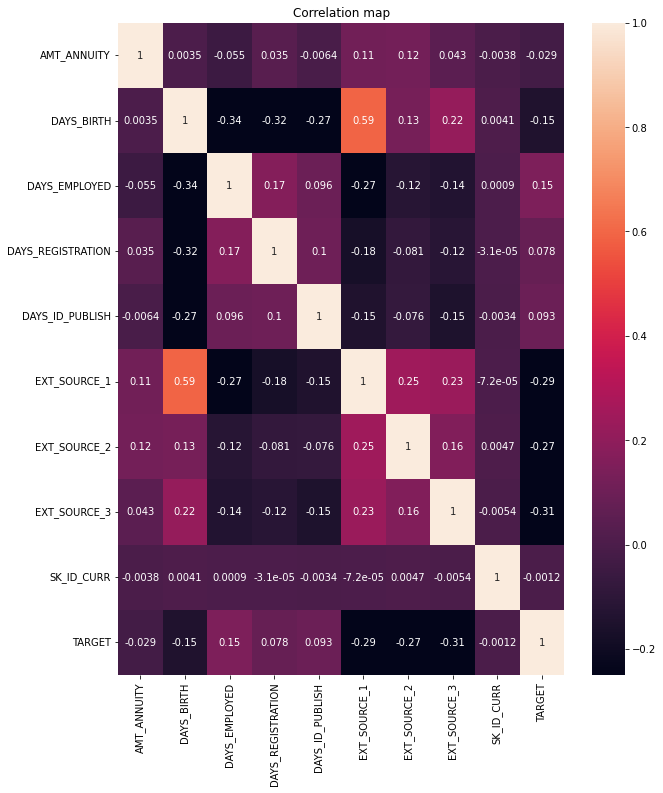

In [89]:
corr = train_df.corr()
plt.figure(figsize = (10,12))
sns.heatmap(corr, annot = True, vmin = -0.25)
plt.title("Correlation map")

In [90]:
corr["TARGET"].sort_values(ascending = False)

TARGET               1.000000
DAYS_EMPLOYED        0.145963
DAYS_ID_PUBLISH      0.092979
DAYS_REGISTRATION    0.078065
SK_ID_CURR          -0.001214
AMT_ANNUITY         -0.028583
DAYS_BIRTH          -0.146646
EXT_SOURCE_2        -0.273014
EXT_SOURCE_1        -0.288011
EXT_SOURCE_3        -0.314028
Name: TARGET, dtype: float64

Linear correlations are the strongest between the target and the extra sources 1, 2 and 3. 

### Logistic Regression 

##### Spliting the train set 

In [91]:
train_set, test_set = train_test_split(train_df, test_size = 0.2,random_state = 42)

#### Seperating the target from the sets

In [92]:
train_set_labels = train_set["TARGET"].copy()
train_set = train_set.drop("TARGET", axis = 1)
test_set_labels = test_set["TARGET"].copy()
test_set = test_set.drop("TARGET", axis = 1)

##### Filling empty values

In [93]:
imputer.fit(train_set)
train_set = imputer.transform(train_set)
test_set = imputer.transform(test_set)

##### Scaling data

In [94]:
scaler.fit(train_set)
train_set = scaler.transform(train_set)
test_set = scaler.transform(test_set)

##### Applying the model

In [95]:
log_reg_ = LogisticRegression(C = 0.0001)
log_reg_.fit(train_set, train_set_labels)
reg_predictions_ = log_reg_.predict(test_set)

##### AUC ROC Curve

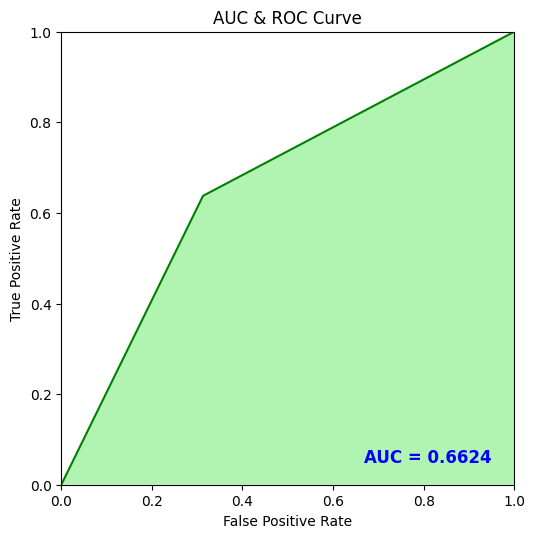

In [96]:
auc_log = metrics.roc_auc_score(test_set_labels, reg_predictions_)

false_positive_rate, true_positive_rate, thresolds = metrics.roc_curve(test_set_labels, reg_predictions_)

plt.figure(figsize=(8, 6), dpi=100)
plt.axis('scaled')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.title("AUC & ROC Curve")
plt.plot(false_positive_rate, true_positive_rate, 'g')
plt.fill_between(false_positive_rate, true_positive_rate, facecolor='lightgreen', alpha=0.7)
plt.text(0.95, 0.05, 'AUC = %0.4f' % auc_log, ha='right', fontsize=12, weight='bold', color='blue')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

##### Confusion matrix

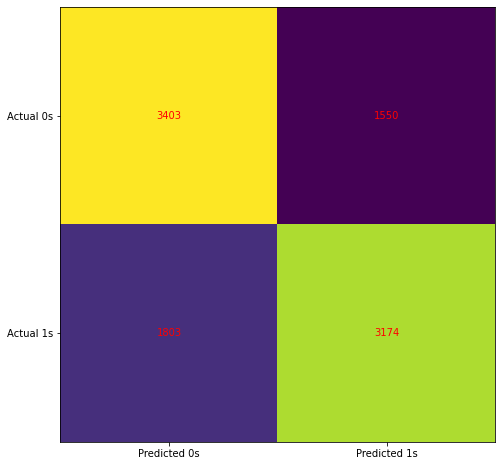

In [97]:
cm_ = confusion_matrix(test_set_labels,reg_predictions_)
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(cm_)
ax.grid(False)
ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted 0s', 'Predicted 1s'))
ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual 0s', 'Actual 1s'))
ax.set_ylim(1.5, -0.5)
for i in range(2):
    for j in range(2):
        ax.text(j, i, cm_[i, j], ha='center', va='center', color='red')

##### Classification report

In [98]:
cr = classification_report(test_set_labels, reg_predictions_)
print(cr)

              precision    recall  f1-score   support

           0       0.65      0.69      0.67      4953
           1       0.67      0.64      0.65      4977

    accuracy                           0.66      9930
   macro avg       0.66      0.66      0.66      9930
weighted avg       0.66      0.66      0.66      9930



In this part we created a dataset only with the selected features of Boruta. We preprocessed the set and applied a Logistic Regression algorithm with a slight modification of the paramaters. 
The Auc Roc curve shows that the model's classification ability is minimum. The confusion matrix gives us an idea of the distribution of True postives/negatives and  False positives/negatives.
The model's accuracy is about 0,66 which mean out of all the instances predicted, 66% were correctly predicted.
Precision is 0,65 for class 0, which means that out of all the instances for which the model predicted 0, 65% of them were actualy 0.
Recall is 0.69 for class 0, which means that out of all the instances that actually have a target of 0, 69% were predicted correctly by our model.
This is not bad result for a base line model. Next we'll try Random Forest classifier 

### Random Forest Classifier

#### Tuning and training the model

In [99]:
# Import the model with its default parameters
ran_for = RandomForestClassifier(random_state = 42)
pprint(ran_for.get_params())

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}


In [100]:
# Define hyperparameters to try out 

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

##### Randomized grid search 

In [101]:
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}


In [103]:
# Use the random grid to search for best hyperparameters
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = ran_for, param_distributions = random_grid, n_iter = 100, cv = 3,
                               verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(train_set, train_set_labels)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=2)

In [105]:
# Extract the best parameters
best_rf = rf_random.best_estimator_
best_rf

RandomForestClassifier(max_depth=10, max_features='sqrt', min_samples_leaf=4,
                       n_estimators=400, random_state=42)

In [107]:
# Make predictions
rf_pred = best_rf.predict(test_set)

Here we first imported Random Forest Classifier and took a look at its default parameters. Since the default parameters are rarely the best ones to use, we did a grid search and came up with the best combination of parameters that yields the best results

##### AUC ROC CURVE

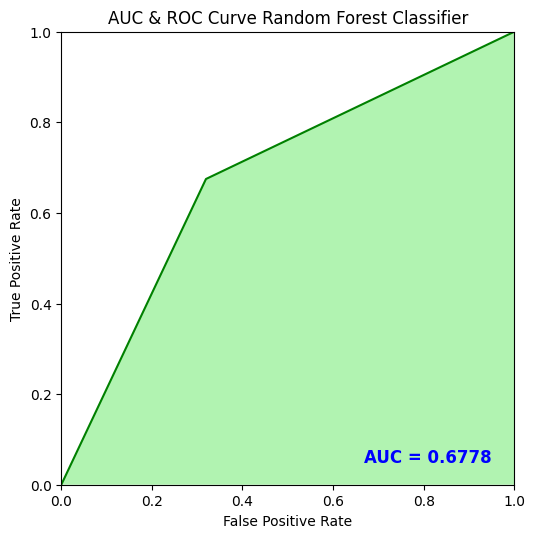

In [108]:
auc_rf = metrics.roc_auc_score(test_set_labels, rf_pred)

false_positive_rate, true_positive_rate, thresolds = metrics.roc_curve(test_set_labels, rf_pred)

plt.figure(figsize=(8, 6), dpi=100)
plt.axis('scaled')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.title("AUC & ROC Curve Random Forest Classifier")
plt.plot(false_positive_rate, true_positive_rate, 'g')
plt.fill_between(false_positive_rate, true_positive_rate, facecolor='lightgreen', alpha=0.7)
plt.text(0.95, 0.05, 'AUC = %0.4f' % auc_rf, ha='right', fontsize=12, weight='bold', color='blue')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

##### Confusion matrix

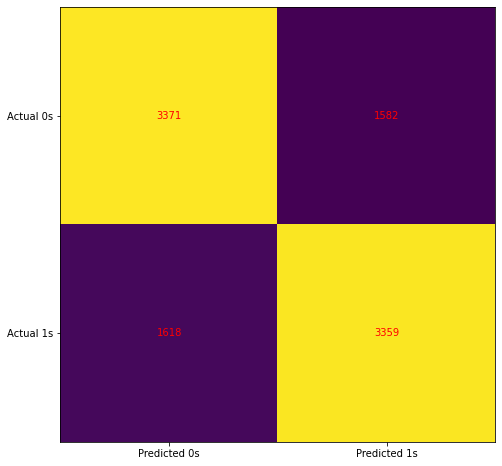

In [119]:
cm_rf = confusion_matrix(test_set_labels,rf_pred)
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(cm_rf)
ax.grid(False)
ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted 0s', 'Predicted 1s'))
ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual 0s', 'Actual 1s'))
ax.set_ylim(1.5, -0.5)
for i in range(2):
    for j in range(2):
        ax.text(j, i, cm_rf[i, j], ha='center', va='center', color='red')

##### Classification report

In [110]:
cr_rf = classification_report(test_set_labels, rf_pred)
print(cr_rf)

              precision    recall  f1-score   support

           0       0.68      0.68      0.68      4953
           1       0.68      0.67      0.68      4977

    accuracy                           0.68      9930
   macro avg       0.68      0.68      0.68      9930
weighted avg       0.68      0.68      0.68      9930



The Auc Roc curve shows that the model's classification ability is slightly better that that of Logistic regression. The confusion matrix gives us an idea of the distribution of True postives/negatives and False positives/negatives, and we see that the false positives are less than the previous model.
The model's accuracy is about 0,68 which mean out of all the instances predicted, 68% were correctly predicted.
Precision is 0,68 for class 0, which means that out of all the instances for which the model predicted 0, 68% of them were actualy 0.
Recall is 0.68 for class 0, which means that out of all the instances that actually have a target of 0,68% were predicted correctly by our model.

### XGBoost

##### Grid Search 

In [111]:
# Tune the hyperparameters of the algirthm using grid search 
# Set constant parameters of the classifier
estimator = xgb.XGBClassifier(
    objective= 'binary:logistic',
    nthread=4,
    seed=42,
    use_label_encoder=False,
    eval_metric='mlogloss'
)

In [112]:
# Specify tunable parameters and range of values
parameters = {
    'max_depth': range (2, 10, 1),
    'n_estimators': range(60, 220, 40),
    'learning_rate': [0.1, 0.01, 0.05]
}

In [113]:
# Configure the grid search and compare the results
grid_search = GridSearchCV(
    estimator=estimator,
    param_grid=parameters,
    scoring = 'roc_auc',
    n_jobs = 10,
    cv = 10,
    verbose=True
)

In [114]:
# Train the data
grid_search.fit(train_set, train_set_labels)

Fitting 10 folds for each of 96 candidates, totalling 960 fits


GridSearchCV(cv=10,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     enable_categorical=False,
                                     eval_metric='mlogloss', gamma=None,
                                     gpu_id=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, mo...
                                     n_estimators=100, n_jobs=None, nthread=4,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, reg_alpha=None,
                  

In [117]:
# Get the best parameters and predict test set
best_xgb = grid_search.best_estimator_
xgb_pred = best_xgb.predict(test_set)

##### AUC ROC CURVE

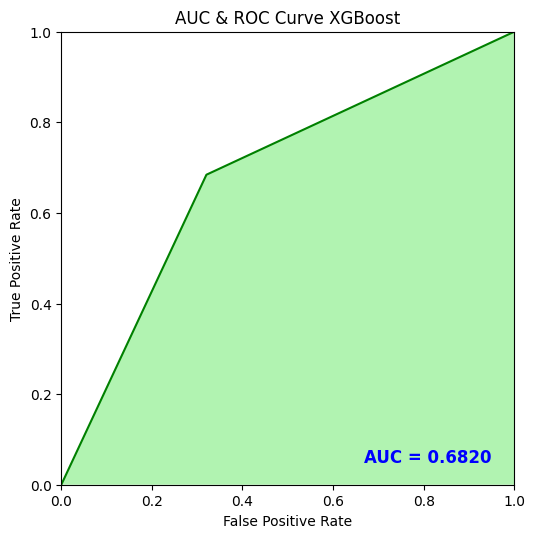

In [118]:
auc_xgb = metrics.roc_auc_score(test_set_labels, xgb_pred)

false_positive_rate, true_positive_rate, thresolds = metrics.roc_curve(test_set_labels, xgb_pred)

plt.figure(figsize=(8, 6), dpi=100)
plt.axis('scaled')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.title("AUC & ROC Curve XGBoost")
plt.plot(false_positive_rate, true_positive_rate, 'g')
plt.fill_between(false_positive_rate, true_positive_rate, facecolor='lightgreen', alpha=0.7)
plt.text(0.95, 0.05, 'AUC = %0.4f' % auc_xgb, ha='right', fontsize=12, weight='bold', color='blue')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

##### Confusion matrix

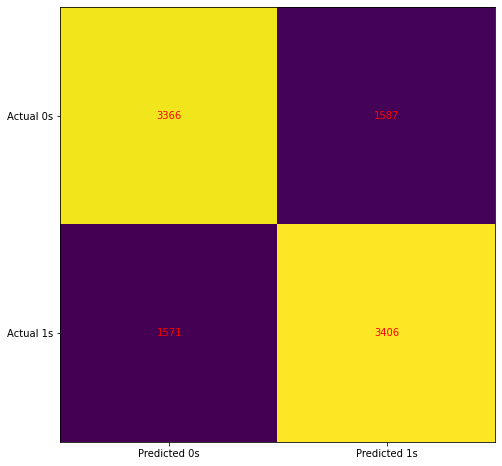

In [120]:
cm_xgb = confusion_matrix(test_set_labels,xgb_pred)
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(cm_xgb)
ax.grid(False)
ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted 0s', 'Predicted 1s'))
ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual 0s', 'Actual 1s'))
ax.set_ylim(1.5, -0.5)
for i in range(2):
    for j in range(2):
        ax.text(j, i, cm_xgb[i, j], ha='center', va='center', color='red')

##### Classification report 

In [122]:
cr_xgb = classification_report(test_set_labels, xgb_pred)
print(cr_xgb)

              precision    recall  f1-score   support

           0       0.68      0.68      0.68      4953
           1       0.68      0.68      0.68      4977

    accuracy                           0.68      9930
   macro avg       0.68      0.68      0.68      9930
weighted avg       0.68      0.68      0.68      9930



For XGB, we performed the grid search first as well. The Auc Roc curve shows that the model's classification ability is slightly better that that of Random Forest Classifier. The confusion matrix gives us an idea of the distribution of True postives/negatives and False positives/negatives, and we see that the false positives are less than the previous model. The model's accuracy is about 0,68 which mean out of all the instances predicted, 68% were correctly predicted. Precision is 0,68 for class 0, which means that out of all the instances for which the model predicted 0, 68% of them were actualy 0. Recall is 0.68 for class 0, which means that out of all the instances that actually have a target of 0,68% were predicted correctly by our model.

### Support vector machine

##### Grid Search 

In [123]:
from sklearn.svm import SVC
# defining parameter range
param_grid = {'C': [0.1, 1, 10, 100, 1000],
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf']}
 
grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3)
 
# fitting the model for grid search
grid.fit(train_set, train_set_labels)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV 1/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.667 total time=  52.6s
[CV 2/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.671 total time=  53.1s
[CV 3/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.675 total time=  54.7s
[CV 4/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.670 total time=  54.2s
[CV 5/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.665 total time=  53.8s
[CV 1/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.663 total time=  52.2s
[CV 2/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.670 total time=  53.6s
[CV 3/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.670 total time=  54.8s
[CV 4/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.667 total time=  56.3s
[CV 5/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.663 total time=  55.6s
[CV 1/5] END .....C=0.1, gamma=0.01, kernel=rbf;, score=0.658 total time=  42.8s
[CV 2/5] END .....C=0.1, gamma=0.01, kernel=rbf

[CV 2/5] END .......C=1000, gamma=1, kernel=rbf;, score=0.667 total time=12.8min
[CV 3/5] END .......C=1000, gamma=1, kernel=rbf;, score=0.671 total time=13.0min
[CV 4/5] END .......C=1000, gamma=1, kernel=rbf;, score=0.665 total time=14.7min
[CV 5/5] END .......C=1000, gamma=1, kernel=rbf;, score=0.661 total time=15.0min
[CV 1/5] END .....C=1000, gamma=0.1, kernel=rbf;, score=0.667 total time= 2.3min
[CV 2/5] END .....C=1000, gamma=0.1, kernel=rbf;, score=0.673 total time= 2.3min
[CV 3/5] END .....C=1000, gamma=0.1, kernel=rbf;, score=0.674 total time= 2.3min
[CV 4/5] END .....C=1000, gamma=0.1, kernel=rbf;, score=0.669 total time= 2.4min
[CV 5/5] END .....C=1000, gamma=0.1, kernel=rbf;, score=0.667 total time= 2.3min
[CV 1/5] END ....C=1000, gamma=0.01, kernel=rbf;, score=0.667 total time=  51.2s
[CV 2/5] END ....C=1000, gamma=0.01, kernel=rbf;, score=0.672 total time=  51.4s
[CV 3/5] END ....C=1000, gamma=0.01, kernel=rbf;, score=0.669 total time=  52.8s
[CV 4/5] END ....C=1000, gam

GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['rbf']},
             verbose=3)

In [125]:
svm_pred = grid.predict(test_set)

##### AUC ROC Curve 

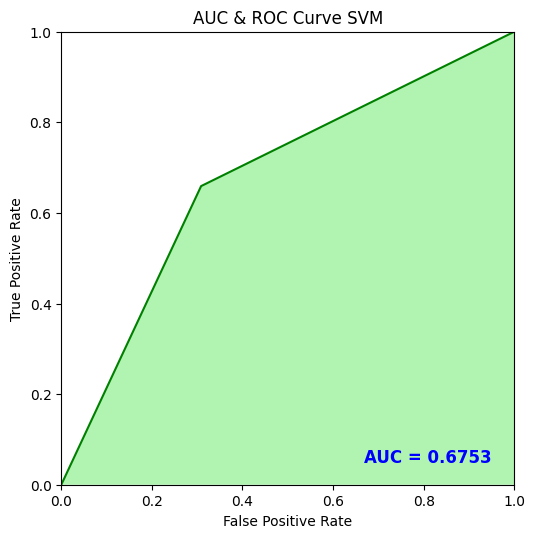

In [126]:
auc_svm = metrics.roc_auc_score(test_set_labels, svm_pred)

false_positive_rate, true_positive_rate, thresolds = metrics.roc_curve(test_set_labels, svm_pred)

plt.figure(figsize=(8, 6), dpi=100)
plt.axis('scaled')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.title("AUC & ROC Curve SVM")
plt.plot(false_positive_rate, true_positive_rate, 'g')
plt.fill_between(false_positive_rate, true_positive_rate, facecolor='lightgreen', alpha=0.7)
plt.text(0.95, 0.05, 'AUC = %0.4f' % auc_svm, ha='right', fontsize=12, weight='bold', color='blue')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

##### Confusion Matrix

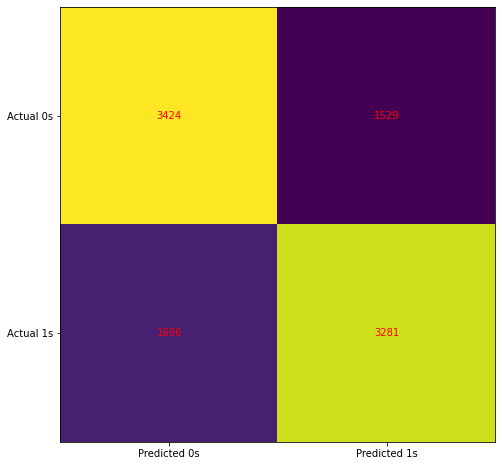

In [127]:
cm_svm = confusion_matrix(test_set_labels,svm_pred)
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(cm_svm)
ax.grid(False)
ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted 0s', 'Predicted 1s'))
ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual 0s', 'Actual 1s'))
ax.set_ylim(1.5, -0.5)
for i in range(2):
    for j in range(2):
        ax.text(j, i, cm_svm[i, j], ha='center', va='center', color='red')

##### Classification report

In [128]:
cr_svm = classification_report(test_set_labels, svm_pred)
print(cr_svm)

              precision    recall  f1-score   support

           0       0.67      0.69      0.68      4953
           1       0.68      0.66      0.67      4977

    accuracy                           0.68      9930
   macro avg       0.68      0.68      0.68      9930
weighted avg       0.68      0.68      0.68      9930



For SVM, we performed the grid search first as well. The Auc Roc curve shows that the model's classification ability is slightly worse that that of Random Forest Classifier. The confusion matrix gives us an idea of the distribution of True postives/negatives and False positives/negatives, and we see that the false positives are more than the previous model. The model's accuracy is about 0,68 which mean out of all the instances predicted, 68% were correctly predicted. Precision is 0,67 for class 0, which means that out of all the instances for which the model predicted 0, 67% of them were actualy 0. Recall is 0.69 for class 0, which means that out of all the instances that actually have a target of 0,69% were predicted correctly by our model.

### Test data Predictions

In [136]:
# Filling empty values
train_df = train_df.drop(["TARGET"], axis = 1)
imputer.fit(train_df)
test_df = imputer.transform(test_df)

In [137]:
# Scaling data
scaler.fit(train_df)
test_df = scaler.transform(test_df)

In [159]:
# Creating the final dataframe
final_pred = best_xgb.predict_proba(test_df)[:, 1]
final_df = pd.DataFrame()
final_df["SK_ID_CURR"] = ids_test
final_df["TARGET"] = final_pred
final_df.head(5)

,SK_ID_CURR,TARGET
0,100001,0.340499
1,100005,0.504905
2,100013,0.157655
3,100028,0.358247
4,100038,0.635723


In [160]:
final_df.to_csv("XGBoost predictions.csv", index = False)

### Conclusion 

After trying out 4 models with their most suitable parameters, we see that they have slighlty different performance measure score. In our case, we've chosen XGBoost to predict the final test set because it has the highest accuracy, precision and recall scores as well as the minimum of false positives. False positives are particularily important here because it's much more serious to predict that a client would pay back when they won't, than to predict that a client wouldn't pay when they would. 
After having chosen the model, we predicted the test set and gave back the results as a csv file which contains the ids of the clients and the percentage of them defaulting on their loans as was requested. 
This is only a preliminary notebook in which we used only the train and test tests. There are other files that we'll use in future to further enhance the models.